<center>
    <h2>US 2020 elections: tweets sentiment analysis and most discussed topics</h2>
</center>

Welcome to this notebook where we will analyze the tweets for the 2020 elections using Python. The dataset can be found here: [2020 Election Tweets Dataset](https://www.kaggle.com/datasets/manchunhui/us-election-2020-tweets/data). 

### Imports

In [2]:
import pandas as pd
import os
import re
import wordninja
from datasketch import MinHash, MinHashLSH
from typing import Dict, List, Set, Tuple
import networkx as nx
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from community import community_louvain
import plotly.graph_objects as go
import plotly.express as px
from concurrent.futures import ThreadPoolExecutor
from plotly.subplots import make_subplots
import math
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
import matplotlib.pyplot as plt

### Data extraction and cleaning

In the following code we start by reading the csv files and creating a single panda's dataframe out of them. We then proceed to clean the data: 
- Removing links and then dropping duplicates tweets
- Remove the tweets that do not come from one of the 51 US states (including District of Columbia)
- Split the dataframe into 4 splits using RegEx to check if any of the two candidates are mentioned:
    - `df` includes all the tweets from The US 
    - `filtered_tweets_trump` includes all the tweets that mention Trump but not Biden
    - `filtered_tweets_biden` includes all the tweets that mention Biden but not Trump
    - `filtered_tweets` includes all the tweets that mention either Trump or Biden but not both

The initial dataset consist of 1747805 tweets. After the cleaning we end up with the following: `df` = 284874, `filtered_tweets_trump` = 108299, `filtered_tweets_biden` = 80177 and `filtered_tweets` = 188476. The function `process_tweet` is also defined here, and will be used later, to clean the hashtag and split them into single words (e.g. #TrumpIsOrange = Trump Is Orange). 

In [3]:
path = os.getcwd()
if os.name == "nt":  # For Windows
    path_trump = path + "\\data\\hashtag_donaldtrump.csv"
    path_biden = path + "\\data\\hashtag_joebiden.csv"
else:  # For Unix/Linux/Mac
    path_trump = path + "/data/hashtag_donaldtrump.csv"
    path_biden = path + "/data/hashtag_joebiden.csv"

trump = pd.read_csv(path_trump, lineterminator="\n")
biden = pd.read_csv(path_biden, lineterminator="\n")
trump["source"] = "Trump"
biden["source"] = "Biden"
# Concatenate and remove duplicates
df = pd.concat([trump, biden], ignore_index=True)
df = df.drop_duplicates()

# Replace URLs with a placeholder text
df["tweet"] = df["tweet"].apply(lambda x: re.sub(r"http\S+", "[]", x))
# Drop duplicates based on the cleaned tweet text
df = df.drop_duplicates(subset=["tweet"])

us_states = [
    "Alabama",
    "Alaska",
    "Arizona",
    "Arkansas",
    "California",
    "Colorado",
    "Connecticut",
    "Delaware",
    "District of Columbia",
    "Florida",
    "Georgia",
    "Hawaii",
    "Idaho",
    "Illinois",
    "Indiana",
    "Iowa",
    "Kansas",
    "Kentucky",
    "Louisiana",
    "Maine",
    "Maryland",
    "Massachusetts",
    "Michigan",
    "Minnesota",
    "Mississippi",
    "Missouri",
    "Montana",
    "Nebraska",
    "Nevada",
    "New Hampshire",
    "New Jersey",
    "New Mexico",
    "New York",
    "North Carolina",
    "North Dakota",
    "Ohio",
    "Oklahoma",
    "Oregon",
    "Pennsylvania",
    "Rhode Island",
    "South Carolina",
    "South Dakota",
    "Tennessee",
    "Texas",
    "Utah",
    "Vermont",
    "Virginia",
    "Washington",
    "West Virginia",
    "Wisconsin",
    "Wyoming",
]

df = df[df["state"].isin(us_states)]

frequent_names_trump = [
    "Trump",
    "Donald" "Donald Trump",
    "@realDonaldTrump",
    "The Donald",
    "45",
    "Donald J. Trump",
    "DJT",
    "The Trump Administration",
    "Trumpster",
    "POTUS",
    "@POTUS",
    "Republican",
    "Republicans",
    "GOP",
    "MAGA",
    "Right Wing",
    "the Right",
]
frequent_names_biden = [
    "Biden",
    "Joe Biden",
    "@JoeBiden",
    "The Biden",
    "46",
    "Joseph R. Biden",
    "JRB",
    "The Biden Administration",
    "Bidenster",
    "Joe",
    "Joseph",
    "Joseph Biden",
    "Sleepy Joe",
    "Uncle Joe",
    "Dems",
    "Democrat",
    "Democrats",
    "Left Wing",
    "The Left",
]
pattern_trump = "|".join(frequent_names_trump)
pattern_biden = "|".join(frequent_names_biden)

# Create boolean masks where tweets contain any of the frequent names
mask_trump = df["tweet"].str.contains(pattern_trump, case=False, na=False)
mask_biden = df["tweet"].str.contains(pattern_biden, case=False, na=False)

# Combine the masks to filter for tweets containing Trump names but not Biden names or vice versa
testdf = df.copy()
testdf["tweet_about"] = "None"
filtered_tweets_trump = df[mask_trump & ~mask_biden]
filtered_tweets_biden = df[mask_biden & ~mask_trump]

testdf.loc[mask_trump & ~mask_biden, "tweet_about"] = "trump"
testdf.loc[mask_biden & ~mask_trump, "tweet_about"] = "biden"

filtered_tweets = testdf[(mask_trump & ~mask_biden) ^ (mask_biden & ~mask_trump)]
filtered_tweets = filtered_tweets.drop_duplicates(subset=["tweet"])

wordninja.DEFAULT_LANGUAGE_MODEL = wordninja.LanguageModel("wordninja_words_our.txt.gz")


def process_tweet(text):
    def split_hashtag(match):
        words = wordninja.split(match.group())
        return " ".join(words)

    # Remove all URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Replace all hashtags with split words
    processed_text = re.sub(r"#\w+\b", split_hashtag, text)
    return processed_text


# Example usage
# text = "Check this out: https://example.com The US is the Best Country in the world! #USA #US #America!! #UnitedStates!"
# processed_text = process_tweet(text)
# print(processed_text)

### Topic Clustering Algorithm

This algorithm performs advanced text clustering using a combination of techniques:
- MinHash for efficient tweet similarity estimation
- Locality-Sensitive Hashing (LSH) for candidate pair generation
- Locality-Sensitive Hashing (LSH) for candidate pair generation
- TF-IDF for term importance extraction


In particular, every tweet goes through the shingling process, and its MinHash signature is created via the batched MinHash algorithm. The next step is done using the LSH algorithm to help identify candidate pairs (we are using the banding technique to speed up the process and lower memory consumption). We then use these similarities to construct a graph that has similarity scores as weights, and we partition it via the Louvain Community Detection algorithm. As a last step, we iteratively force the merging of most similar clusters to obtain a reasonable number of topics. The results are presented via a plot that shows the most significant terms per cluster using TF-IDF vectorization. 

We consider tweets that have a similarity between $threshold \leq similarity < 0.40$ since we noticed that a similarity above 0.4, for such short texts, indicates they are probably the same or they differ by only some hashtags. A wide selection of parameters is available, and more fine-tuning can be done with adequate time:
```python
clusters = find_topic_clusters(
    docs, 
    threshold=0.2, # jaccard min threshold
    num_perm=120, # hash funcitons per each tweet
    q=4, # shingle size  
    min_cluster_size=40, # minumin cluster size (if less cluster is discarded)
    n_terms=TERMS, # Terms to show in graph per each cluster
    batch_size=1000, # batch size for batchd MinHash processing 
    n_clusters=6, # final number of cluster
    max_docs=300_000, # if more then 300000 you might need more RAM
)
```





In [ ]:
# POLITICAL_STOP_WORDS = [
#     "trump",
#     "biden",
#     "donald",
#     "joe",
#     "potus",
#     "2020",
#     "trumps",
#     "realdonaldtrump",
#     "harris",
#     "save",
#     "yep",
#     "yes",
#     "nope",
#     "no",
#     "fa",
#     "oh",
#     "nytimes",
#     "wow",
#     "tells",
#     "omg",
#     "wait",
#     "look",
#     "abc" "abcnews",
#     "cnn",
#     "fox",
#     "foxnews",
#     "msnbc",
#     "nbc",
#     "nbcnews",
#     "cbs",
#     "cbsnews",
#     "news",
#     "joebiden",
#     "did",
#     "won",
#     "wins",
#     "19",
#     "kamala",
#     "wouldn",
#     "rawstory",
# ]
# CUSTOM_STOP_WORDS = list(ENGLISH_STOP_WORDS) + POLITICAL_STOP_WORDS
# MAX_FEATURES = 3000


# def create_vectorizer(max_features: int = MAX_FEATURES) -> TfidfVectorizer:
#     """Create a consistent TfidfVectorizer with standard parameters"""
#     return TfidfVectorizer(
#         stop_words=CUSTOM_STOP_WORDS,
#         max_features=max_features,
#         ngram_range=(1, 1),  # unigrams
#         min_df=7,  # minimum document frequency
#         max_df=0.7,  # maximum document frequency
#     )


# def create_shingles(text: str, q: int = 5) -> Set[str]:
#     """Convert text into q-grams (shingles)"""
#     # Process only if text is long enough
#     if len(text) < q:
#         return set()
#     return set(text[i : i + q] for i in range(len(text) - q + 1))


# def batch_minhash(
#     docs: Dict[int, str], batch_size: int = 1000, num_perm: int = 128, q: int = 5
# ) -> Dict[int, MinHash]:
#     """Create MinHash objects in batches"""
#     minhashes = {}

#     def process_batch(batch_items):
#         batch_results = {}
#         for doc_id, text in batch_items:
#             m = MinHash(num_perm=num_perm)
#             shingles = create_shingles(text, q)
#             for shingle in shingles:
#                 m.update(shingle.encode("utf-8"))
#             batch_results[doc_id] = m
#         return batch_results

#     # Process documents in batches
#     items = list(docs.items())
#     with ThreadPoolExecutor() as executor:
#         futures = []
#         for i in range(0, len(items), batch_size):
#             batch = items[i : i + batch_size]
#             futures.append(executor.submit(process_batch, batch))

#         for future in futures:
#             minhashes.update(future.result())

#     return minhashes


# def find_candidate_pairs(
#     minhashes: Dict[int, MinHash], threshold: float
# ) -> Set[Tuple[int, int]]:
#     """
#     Memory-efficient candidate pair generation using LSH with iterative processing

#     Args:
#         minhashes: Dictionary of document IDs to MinHash signatures
#         threshold: Jaccard similarity threshold for considering pairs

#     Returns:
#         Set of document ID pairs that are potentially similar
#     """
#     # Limit memory by processing documents in batches
#     candidate_pairs = set()
#     doc_ids = list(minhashes.keys())

#     # Process in manageable chunks to reduce memory pressure
#     for i in range(0, len(doc_ids), 10000):  # Adjust batch size as needed
#         batch_doc_ids = doc_ids[i : i + 10000]

#         # Create a temporary LSH index for this batch
#         lsh = MinHashLSH(
#             threshold=threshold, num_perm=len(next(iter(minhashes.values())).hashvalues)
#         )

#         # Insert documents from this batch into LSH
#         for doc_id in batch_doc_ids:
#             lsh.insert(doc_id, minhashes[doc_id])

#         # Find pairs within this batch and across previous batches
#         for doc_id in batch_doc_ids:
#             similar_ids = lsh.query(minhashes[doc_id])

#             for similar_id in similar_ids:
#                 if similar_id != doc_id:
#                     # Ensure consistent pair ordering
#                     candidate_pair = tuple(sorted((doc_id, similar_id)))
#                     candidate_pairs.add(candidate_pair)

#         # Clear LSH to free memory
#         del lsh

#     return candidate_pairs


# def merge_similar_clusters(
#     clusters: Dict[int, Dict], docs: Dict[int, str], target_clusters: int, n_terms: int
# ) -> Dict[int, Dict]:
#     """Merge similar clusters until reaching target number of clusters"""
#     if len(clusters) <= target_clusters:
#         return clusters

#     # Create TF-IDF vectors for each cluster
#     vectorizer = TfidfVectorizer(stop_words=CUSTOM_STOP_WORDS)
#     cluster_texts = {}
#     for cluster_id, info in clusters.items():
#         # Concatenate all texts in cluster
#         cluster_text = " ".join([docs[doc_id] for doc_id in info["documents"]])
#         cluster_texts[cluster_id] = cluster_text

#     while len(clusters) > target_clusters:
#         # Recalculate TF-IDF matrix and similarities for current clusters
#         current_cluster_ids = list(clusters.keys())
#         tfidf_matrix = vectorizer.fit_transform(
#             [cluster_texts[cid] for cid in current_cluster_ids]
#         )
#         similarities = cosine_similarity(tfidf_matrix)

#         # Find most similar pair of clusters
#         max_similarity = -1
#         merge_pair = None

#         for i in range(len(current_cluster_ids)):
#             for j in range(i + 1, len(current_cluster_ids)):
#                 if similarities[i, j] > max_similarity:
#                     max_similarity = similarities[i, j]
#                     merge_pair = (current_cluster_ids[i], current_cluster_ids[j])

#         if merge_pair is None:
#             break

#         # Merge clusters
#         cluster1, cluster2 = merge_pair
#         new_docs = clusters[cluster1]["documents"] + clusters[cluster2]["documents"]
#         new_texts = [docs[doc_id] for doc_id in new_docs]

#         # Update cluster_texts for the merged cluster
#         cluster_texts[cluster1] = " ".join([docs[doc_id] for doc_id in new_docs])

#         # Create new cluster info
#         clusters[cluster1] = {
#             "documents": new_docs,
#             "size": len(new_docs),
#             "top_terms": extract_top_terms(new_texts, n_terms=n_terms),
#         }

#         # Remove merged cluster and its text
#         del clusters[cluster2]
#         del cluster_texts[cluster2]

#     return clusters


# def extract_top_terms(texts: List[str], n_terms: int = 5) -> List[str]:
#     """Extract the most significant terms from a group of tweets using TF-IDF"""
#     vectorizer = create_vectorizer()
#     tfidf_matrix = vectorizer.fit_transform(texts)

#     avg_scores = np.array(tfidf_matrix.mean(axis=0))[0]
#     top_indices = avg_scores.argsort()[-n_terms:][::-1]

#     feature_names = vectorizer.get_feature_names_out()
#     return [feature_names[i] for i in top_indices]


# def find_topic_clusters(
#     docs: Dict[int, str],
#     threshold: float = 0.05,
#     num_perm: int = 120,
#     q: int = 4,
#     min_cluster_size: int = 5,
#     n_terms: int = 5,
#     batch_size: int = 1000,
#     n_clusters: int = 10,
#     max_docs: int = None,
# ) -> Dict[int, Dict]:
#     """
#     Optimized version with memory-conscious processing
#     """
#     # Optionally limit number of documents
#     if max_docs is not None and len(docs) > max_docs:
#         print(f"Warning: Large dataset detected. Using first {max_docs} documents.")
#         docs = dict(list(docs.items())[:max_docs])

#     # Initialize similarity graph
#     similarity_graph = nx.Graph()
#     similarity_graph.add_nodes_from(docs.keys())

#     # Create MinHash signatures in batches
#     print("Creating MinHash signatures...")
#     minhashes = batch_minhash(docs, batch_size=batch_size, num_perm=num_perm, q=q)

#     # Find candidate pairs using LSH banding
#     print("Finding candidate pairs...")
#     candidate_pairs = find_candidate_pairs(minhashes, threshold)

#     # Verify candidate pairs and build similarity graph
#     print("Building similarity graph...")
#     for doc_id1, doc_id2 in candidate_pairs:
#         similarity = minhashes[doc_id1].jaccard(minhashes[doc_id2])
#         if threshold <= similarity < 0.40:
#             similarity_graph.add_edge(doc_id1, doc_id2, weight=similarity)

#     # Find clusters using Louvain
#     print("Finding communities...")
#     partition = community_louvain.best_partition(similarity_graph)

#     # Create cluster dictionary
#     clusters = defaultdict(list)
#     for doc_id, cluster_id in partition.items():
#         clusters[cluster_id].append(doc_id)

#     # Create cluster info with batched TF-IDF calculation
#     print("Creating cluster information...")
#     cluster_info = {}
#     vectorizer = create_vectorizer()

#     # Process clusters that meet minimum size requirement
#     valid_clusters = {
#         cid: doc_ids
#         for cid, doc_ids in clusters.items()
#         if len(doc_ids) >= min_cluster_size
#     }

#     if valid_clusters:
#         # Prepare texts for all valid clusters at once
#         all_texts = []
#         cluster_doc_mapping = []
#         for cluster_id, doc_ids in valid_clusters.items():
#             cluster_texts = [docs[doc_id] for doc_id in doc_ids]
#             all_texts.extend(cluster_texts)
#             cluster_doc_mapping.extend([cluster_id] * len(cluster_texts))

#         # Calculate TF-IDF for all texts at once
#         tfidf_matrix = vectorizer.fit_transform(all_texts)
#         feature_names = vectorizer.get_feature_names_out()

#         # Process each cluster
#         current_idx = 0
#         for cluster_id, doc_ids in valid_clusters.items():
#             n_docs = len(doc_ids)
#             cluster_tfidf = tfidf_matrix[current_idx : current_idx + n_docs]

#             # Calculate average TF-IDF scores for the cluster
#             avg_scores = np.array(cluster_tfidf.mean(axis=0))[0]
#             top_indices = avg_scores.argsort()[-n_terms:][::-1]  # Get top n_terms

#             cluster_info[cluster_id] = {
#                 "documents": sorted(doc_ids),
#                 "size": n_docs,
#                 "top_terms": [feature_names[i] for i in top_indices],
#             }
#             current_idx += n_docs

#     # Merge similar clusters if needed
#     if len(cluster_info) > n_clusters:
#         cluster_info = merge_similar_clusters(cluster_info, docs, n_clusters, n_terms)

#     return cluster_info


# def create_cluster_wordclouds(clusters, max_terms=10):
#     """
#     Create a visualization of word clouds for each cluster using Plotly
#     to maintain consistency with create_cluster_word_viz()
#     """
#     n_clusters = len(clusters)
#     n_cols = min(3, n_clusters)
#     n_rows = math.ceil(n_clusters / n_cols)

#     fig = make_subplots(
#         rows=n_rows,
#         cols=n_cols,
#         subplot_titles=[f"Cluster {i+1}" for i in range(n_clusters)],
#         vertical_spacing=0.15,
#         horizontal_spacing=0.05,
#     )
#     # Increase font size of subplot titles
#     for annotation in fig.layout.annotations:
#         annotation.font.size = 30  # Font size of subplot titles

#         # Add number of elements to subplot titles
#         cluster_num = int(annotation.text.split()[-1]) - 1
#         cluster_size = len(list(clusters.values())[cluster_num]["documents"])
#         annotation.text += f"<br><sup>({cluster_size} elements)</sup>"
#         annotation.font.size = 20  # Smaller font for element count

#     colors = [
#         "#1f77b4",
#         "#ff7f0e",
#         "#2ca02c",
#         "#d62728",
#         "#9467bd",
#         "#8c564b",
#         "#e377c2",
#         "#7f7f7f",
#         "#bcbd22",
#         "#17becf",
#     ]

#     def get_text_dimensions(term, size):
#         """Estimate text dimensions based on term length and font size"""
#         char_width = size / 2  # Approximate width per character
#         char_height = size  # Approximate height
#         return (
#             len(term) * char_width / 100,
#             char_height / 100,
#         )  # Scale down to plot units

#     def check_overlap(x1, y1, w1, h1, x2, y2, w2, h2, padding=0.1):
#         """Check if two text boxes overlap"""
#         return not (
#             x1 + w1 / 2 + padding < x2 - w2 / 2
#             or x1 - w1 / 2 - padding > x2 + w2 / 2
#             or y1 + h1 / 2 + padding < y2 - h2 / 2
#             or y1 - h1 / 2 - padding > y2 + h2 / 2
#         )

#     def generate_positions(terms, sizes):
#         """Generate non-overlapping positions for terms"""
#         positions = []

#         # Start with center position for first term
#         first_width, first_height = get_text_dimensions(terms[0], sizes[0])
#         positions.append((0, 0, first_width, first_height))

#         # Place remaining terms
#         for i in range(1, len(terms)):
#             term = terms[i]
#             size = sizes[i]
#             width, height = get_text_dimensions(term, size)

#             # Try positions at increasing distances from center
#             base_radius = 0.3  # Start closer to center
#             radius_step = 0.1
#             angle_step = np.pi / 8

#             for radius in np.arange(base_radius, 1.0, radius_step):
#                 for angle in np.arange(0, 2 * np.pi, angle_step):
#                     x = radius * np.cos(angle)
#                     y = radius * np.sin(angle)

#                     # Check overlap with all existing terms
#                     overlaps = False
#                     for px, py, pw, ph in positions:
#                         if check_overlap(x, y, width, height, px, py, pw, ph):
#                             overlaps = True
#                             break

#                     if not overlaps:
#                         positions.append((x, y, width, height))
#                         break

#                 if len(positions) > i:  # If position was found
#                     break

#             # If no position found, place at default position
#             if len(positions) <= i:
#                 positions.append(
#                     (
#                         radius * np.cos(i * 2 * np.pi / len(terms)),
#                         radius * np.sin(i * 2 * np.pi / len(terms)),
#                         width,
#                         height,
#                     )
#                 )

#         return [(x, y) for x, y, w, h in positions]

#     for idx, (_, info) in enumerate(clusters.items()):
#         row = idx // n_cols + 1
#         col = idx % n_cols + 1
#         color = colors[idx % len(colors)]

#         terms = info["top_terms"][:max_terms]

#         # Calculate term sizes
#         base_size = 50
#         size_decay = 0.85
#         term_sizes = [base_size * (size_decay**i) for i in range(len(terms))]

#         # Generate non-overlapping positions
#         positions = generate_positions(terms, term_sizes)

#         # Add terms to plot
#         for i, (term, size, (x, y)) in enumerate(zip(terms, term_sizes, positions)):
#             opacity = 1.0 - (i * 0.5 / len(terms))

#             fig.add_trace(
#                 go.Scatter(
#                     x=[x],
#                     y=[y],
#                     text=[term],
#                     mode="text",
#                     textfont=dict(
#                         size=size,
#                         color=color,
#                         family="Arial Black" if i == 0 else "Arial",
#                     ),
#                     opacity=opacity,
#                     hoverinfo="text",
#                     hovertext=f"Term: {term}",
#                     showlegend=False,
#                 ),
#                 row=row,
#                 col=col,
#             )

#     fig.update_layout(
#         title_text="Topic Clusters - Word Importance",
#         title_x=0.5,
#         title_font_size=35,
#         height=600 * n_rows,
#         width=1500,
#         showlegend=False,
#         paper_bgcolor="white",
#         plot_bgcolor="white",
#     )

#     for i in range(1, n_clusters + 1):
#         fig.update_xaxes(
#             showgrid=False,
#             zeroline=False,
#             showticklabels=False,
#             range=[-1.2, 1.2],
#             row=(i - 1) // n_cols + 1,
#             col=(i - 1) % n_cols + 1,
#         )
#         fig.update_yaxes(
#             showgrid=False,
#             zeroline=False,
#             showticklabels=False,
#             range=[-1.2, 1.2],
#             row=(i - 1) // n_cols + 1,
#             col=(i - 1) % n_cols + 1,
#         )

#     return fig


# TERMS = 6
# docs = {i: tweet for i, tweet in enumerate(df["tweet"])}

# print("Processing hashtags...")
# docs = dict(zip(docs.keys(), map(process_tweet, docs.values())))

# # Find topic clusters
# clusters = find_topic_clusters(
#     docs,
#     threshold=0.2,
#     num_perm=120,
#     q=4,
#     min_cluster_size=40,
#     n_terms=TERMS,
#     batch_size=1000,
#     n_clusters=6,
#     max_docs=300_000,
# )

# print(f"\nFound {len(clusters)} topic clusters:")
# for cluster_id, info in clusters.items():
#     print(f"\nCluster {cluster_id}:")
#     print(f"Size: {info['size']} documents")
#     print(f"Top terms: {', '.join(info['top_terms'])}")
#     print("\nExample documents:")
#     for doc_id in info["documents"][:3]:
#         print(f"- {docs[doc_id][:100]}...")
#     print(24 * "-")

# fig = create_cluster_wordclouds(clusters, max_terms=TERMS)
# fig.show()

# Sentiment Analysis

The following code will add 4 new columns, `positive`, `negative`, and `compound` which refers to the sentiment score, and `likely_party` which classifies a tweet as pro Democrat 1, pro Republican 2 or neutral tweet. The sentiment and the classification is done by:

- First importing relevant libraries, `nltk` for the vader Sentiment Analyzer and  `spacy` to load the language.
- Defining a function `analyze_sentiment` that given a tweet, it will use vader Sentiment Analyzer to calculate the sentiment score. 
- `analyze_sentiment` function also classifies the tweets based on sentiment, for example a tweet is about Biden that has bad sentiment, then the tweet will be classified as Republican
- The function is then applied to every row of the `filtered_tweets` and the dataframe is stored in a .pkl file.

In [ ]:
# !python -m spacy download en_core_web_lg

: 

In [4]:
## Adding additional columns to store sentiment analysis results
filtered_tweets["positive"] = 0.0
filtered_tweets["neutral"] = 0.0
filtered_tweets["negative"] = 0.0
filtered_tweets["compound"] = 0.0
filtered_tweets["likely_party"] = 0  # 0 for unsure, 1 for dem, 2 for rep
nlp = spacy.load("en_core_web_lg")
analyzer = SentimentIntensityAnalyzer()

# Process tweets and calculate sentiment scores
def analyze_sentiment(row):
    tweet = process_tweet(row["tweet"])
    doc = nlp(tweet)
    context = " ".join(
        [token.text for token in doc if token.dep_ in ("nsubj", "dobj", "pobj", "ROOT")]
    )

    # Get the sentiment score from VADER for the context
    sentiment_dict = analyzer.polarity_scores(context)
    row["positive"] = sentiment_dict["pos"]
    row["neutral"] = sentiment_dict["neu"]
    row["negative"] = sentiment_dict["neg"]
    row["compound"] = sentiment_dict["compound"]

    if (sentiment_dict["compound"] < 0.05) and (sentiment_dict["compound"] > -0.05):
        row["likely_party"] = 0
    elif row["tweet_about"] == "biden":
        row["likely_party"] = 1 if sentiment_dict["compound"] > 0 else 2
    elif row["tweet_about"] == "trump":
        row["likely_party"] = 2 if sentiment_dict["compound"] > 0 else 1
    return row


# Apply the sentiment analysis function to each row
# filtered_tweets = filtered_tweets.apply(analyze_sentiment, axis=1)
if not os.path.exists("data/filtered_tweets_final.pkl"):
    for n,row in filtered_tweets.iterrows():
        filtered_tweets.loc[n] = analyze_sentiment(row)
        print(n/len(filtered_tweets)*100, end="\r")

# Save the results to a new pkl file
# =============================================================================
# import pickle as pkl
# with open('filtered_tweets_nlp_2.pkl', 'wb') as f:
#     pkl.dump(filtered_tweets, f)
# =============================================================================

# Load the saved results
# =============================================================================
import pickle as pkl
if os.path.exists("data/filtered_tweets_final.pkl"):
    filtered_tweets = pkl.load(open('data/filtered_tweets_final.pkl', 'rb'))
# =============================================================================

loaded = filtered_tweets.copy()
nue, dem, rep = 0, 0, 0
for i in loaded["likely_party"]:
    if i == 0:
        nue += 1
    elif i == 1:
        dem += 1
    else:
        rep += 1
print(
    f"There are {nue} neutral tweets, {dem} democrat tweets, and {rep} republican tweets."
)
print(
    f"The neutral tweets are {nue/len(loaded)*100}, the democrat tweets are {dem/len(loaded)*100}, and the republican tweets are {rep/len(loaded)*100}."
)

There are 101001 neutral tweets, 51399 democrat tweets, and 36076 republican tweets.
The neutral tweets are 53.58825526857531, the democrat tweets are 27.270846155478683, and the republican tweets are 19.140898575946007.


# Mapping: Sentiments, Baselines, and Differences

The code below visualizes tweet sentiment by US state using a choropleth map with Plotly.

- `state_abbreviations`: A dictionary mapping US state names to their abbreviations.
- `file_path`: The path to the pickle file containing filtered tweets.
- `filtered_tweets`: The DataFrame loaded from the pickle file containing tweet data.
- `tweet_counts_per_state`: A DataFrame containing the count of tweets per state and their state codes.
- `sentiment_counts`: A DataFrame containing the count of tweets per state grouped by sentiment (likely_party).
- `total_democratic_tweets` and `total_republican_tweets`: The total number of democratic and republican tweets, respectively.
- `tweet_ratio`: The ratio of total democratic tweets to total republican tweets.
- `min_dem_prop`, `max_dem_prop`, and `mid_point`: Variables used to define the range and midpoint for the color scale in the choropleth map.
- `fig`: The Plotly figure object representing the choropleth map.

The code calculates tweet counts and sentiment proportions per state, adjusts proportions based on the ratio of total tweets, normalizes the proportions, and then creates a choropleth map to visualize the democratic proportion of tweets by state. The map uses a diverging color scale and includes hover data for tweet counts and sentiment proportions.


In [ ]:
# Define a mapping for US states to Plotly's choropleth map
state_abbreviations = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
}

"""
cwd = os.getcwd()
# Load the filtered tweets from a pickle file
file_path = os.path.join(cwd, 'filtered_tweets_nlp.pkl')
with open(file_path, 'rb') as file:
    filtered_tweets = pickle.load(file)
    
"""

# Calculate tweet counts and sentiment proportions per state
tweet_counts_per_state = filtered_tweets["state"].value_counts().reset_index()
tweet_counts_per_state.columns = ["state", "tweet_count"]
tweet_counts_per_state["state_code"] = tweet_counts_per_state["state"].map(
    state_abbreviations
)

sentiment_counts_no_bias = (
    filtered_tweets.groupby(["state", "likely_party"]).size().unstack(fill_value=0)
)
sentiment_counts_no_bias["total"] = sentiment_counts_no_bias.sum(axis=1)

# Calculate initial proportions
sentiment_counts_no_bias["democratic_proportion"] = sentiment_counts_no_bias.get(1, 0) / (
    sentiment_counts_no_bias[1] + sentiment_counts_no_bias[2]
)
sentiment_counts_no_bias["republican_proportion"] = sentiment_counts_no_bias.get(2, 0) / (
    sentiment_counts_no_bias[1] + sentiment_counts_no_bias[2]
)

sentiment_counts = sentiment_counts_no_bias.copy()


total_democratic_tweets = sentiment_counts[1].sum()
total_republican_tweets = sentiment_counts[2].sum()

# Adjust republican proportions by the ratio of total tweets
tweet_ratio = total_democratic_tweets / total_republican_tweets
sentiment_counts["republican_proportion"] = (
    sentiment_counts["republican_proportion"] * tweet_ratio
)

# Normalize to ensure proportions sum to 1
total_proportion = (
    sentiment_counts["democratic_proportion"]
    + sentiment_counts["republican_proportion"]
)
sentiment_counts["democratic_proportion"] = (
    sentiment_counts["democratic_proportion"] / total_proportion
)
sentiment_counts["republican_proportion"] = (
    sentiment_counts["republican_proportion"] / total_proportion
)

sentiment_counts["democratic_proportion"] = (
    sentiment_counts["democratic_proportion"] * 100
)
sentiment_counts["republican_proportion"] = (
    sentiment_counts["republican_proportion"] * 100
)
# Merge sentiment proportions with tweet counts
tweet_counts_per_state = tweet_counts_per_state.merge(
    sentiment_counts, left_on="state", right_index=True
)


min_dem_prop = tweet_counts_per_state["democratic_proportion"].min()
max_dem_prop = tweet_counts_per_state["democratic_proportion"].max()
mid_point = (min_dem_prop + max_dem_prop) / 2
# Create the choropleth map with discrete color steps
fig = px.choropleth(
    tweet_counts_per_state,
    locations="state_code",
    locationmode="USA-states",
    color="democratic_proportion",
    hover_name="state",
    hover_data={
        "tweet_count": True,
        "democratic_proportion": ":.1f",
        "republican_proportion": ":.1f",
    },
    color_continuous_scale=px.colors.diverging.RdBu[::2],
    labels={"democratic_proportion": "Democratic Proportion"},
    # Define discrete color steps based on proportion
    range_color=[min_dem_prop, max_dem_prop],
    color_continuous_midpoint=mid_point,
)

# Update layout with discrete color steps
fig.update_layout(
    title_text="Tweet Sentiment by State",
    title_x=0.5,
    geo=dict(
        scope="usa",
        projection_type="albers usa",
        showcoastlines=True,
        coastlinecolor="Black",
        showland=True,
        landcolor="white",
        lakecolor="white",
    ),
    coloraxis_colorbar=dict(
        tickmode="array",
        tickvals=[
            min_dem_prop + i * (max_dem_prop - min_dem_prop) / 5 for i in range(6)
        ],
        ticktext=[f"{i*20}%" for i in range(6)],
        title="Democratic Proportion",
    ),
)

fig.show()

35.06108672263974 63.32466522759557 49.19287597511766


The initial choropleth map displayed a red-blue gradient to help determine the political leaning of Twitter users, whether liberal or conservative.

For comparison, we used the `CNN 2020 Size of Lead` map, which visualizes state victory margins with a red-blue gradient, as shown below:

![CNN 2020 Size of Lead](data/cnnmap.jpg)

The following choropleth map uses tweet sentiments to replicate this concept and make it easier to visually compare results.


In this section, we calculate the lead size for each state and visualize it using a custom color scale on a choropleth map.

- `lead_size`: This variable calculates the difference between the democratic and republican proportions for each state.
- `color_scale`: This custom color scale is used to represent different ranges of lead sizes, from deep red (Trump >10%) to deep blue (Biden >10%).

The code below creates a choropleth map to visualize the tweet sentiment lead by state:


In [6]:
# Calculate lead size (difference between democratic and republican proportion)
tweet_counts_per_state["lead_size"] = (
    tweet_counts_per_state["democratic_proportion"] - 50
)

# Create custom color scale for discrete ranges
color_scale = [
    [0, "rgb(165,0,38)"],  # Deep Red (Trump >10%)
    [0.2, "rgb(215,48,39)"],  # Red (Trump 5-10%)
    [0.4, "rgb(244,109,67)"],  # Light Red (Trump 0-5%)
    [0.5, "rgb(255,255,255)"],  # White (Tie)
    [0.6, "rgb(116,169,207)"],  # Light Blue (Biden 0-5%)
    [0.8, "rgb(54,144,192)"],  # Blue (Biden 5-10%)
    [1, "rgb(5,112,176)"],  # Deep Blue (Biden >10%)
]

fig = px.choropleth(
    tweet_counts_per_state,
    locations="state_code",
    locationmode="USA-states",
    color="lead_size",
    hover_name="state",
    color_continuous_scale=color_scale,
    range_color=[-15, 15],
)

fig.update_layout(
    title_text="Tweet Sentiment Lead by State",
    geo=dict(scope="usa"),
    coloraxis_colorbar=dict(
        title="Lead Size",
        ticktext=[
            "Trump >10%",
            "Trump 5-10%",
            "Trump 0-5%",
            "Tie",
            "Biden 0-5%",
            "Biden 5-10%",
            "Biden >10%",
        ],
        tickvals=[-12, -7.5, -2.5, 0, 2.5, 7.5, 12],
        tickmode="array",
    ),
)

The maps now provide a direct comparison between tweet sentiments and the `CNN Lead Size Map`. As hypothesized, the tweet sentiment map shows a more liberal stance compared to the actual 2020 Electoral College outcomes. This discrepancy highlights the potential differences between social media activity and real-world voting behavior, suggesting that Twitter users may lean more liberal than the general voting population. This observation is crucial for understanding the limitations and biases of using social media data to predict or analyze political trends.

The recent elections, namely the 2024 election, showed great discrepency between polling results pre and post election. Therefore, it was also important to compare polling results to our sentiment data as well. The following shows two chorolepth maps: the first being election results from Harvard Polling data visualized similar to the `CNN Lead Size Map`; the second is a gradient map showing our predicted results versus the Harvard Polling data that is being considered as `baseline`.



1. Loads election data from a CSV file.
2. Filters and groups the data by state and candidate, summing the votes.
3. Calculates the total votes per state.
4. Calculates the percentage of votes and the proportion of votes for Joseph R. Biden.
5. Calculates the lead size between Joseph R. Biden and Donald J. Trump.
6. Resets the index to make `state_po` a column.
7. Defines a color scale for visualizing the lead size.
8. Creates a choropleth map using Plotly to visualize the lead size by state.
9. Updates the layout of the map with a title and color axis.
10. Displays the plot.

Variables:
- `cwd`: Current working directory.
- `file_path`: Path to the election data CSV file.
- `df`: DataFrame containing the election data.
- `state_votes`: DataFrame containing the grouped and calculated election data by state.
- `x`: Total votes for Donald J. Trump.
- `y`: Total votes for Joseph R. Biden.
- `color_scale`: List defining the color scale for the choropleth map.
- `baseline_fig`: Plotly figure object for the choropleth map.


In [13]:
# Load election data
cwd = os.getcwd()
file_path = cwd + "/data/PRESIDENT_precinct_general.csv"

# Load the data
df = pd.read_csv(file_path)

# Filter the DataFrame
# Group the filtered DataFrame by state and candidate, and sum the votes
state_votes = df.groupby(["state_po", "candidate"])["votes"].sum().unstack(fill_value=0)

# Calculate the total votes per state
state_votes["total_votes"] = state_votes.sum(axis=1)

# Calculate the percentage of votes for Biden
state_votes["biden_pct"] = (
    state_votes["JOSEPH R BIDEN"] / state_votes["total_votes"] * 100
)
state_votes["democratic_proportion"] = (
    state_votes["JOSEPH R BIDEN"] / state_votes["total_votes"]
)

# Calculate lead size
state_votes["lead_size"] = (
    (state_votes["JOSEPH R BIDEN"] - state_votes["DONALD J TRUMP"])
    / state_votes["total_votes"]
    * 100
)
# Reset the index to make state_po a column
state_votes = state_votes.reset_index()

x = state_votes["DONALD J TRUMP"].sum()
y = state_votes["JOSEPH R BIDEN"].sum()


color_scale = [
    [0, "rgb(165,0,38)"],  # Deep Red (Trump >10%)
    [0.2, "rgb(215,48,39)"],  # Red (Trump 5-10%)
    [0.4, "rgb(244,109,67)"],  # Light Red (Trump 0-5%)
    [0.5, "rgb(255,255,255)"],  # White (Tie)
    [0.6, "rgb(116,169,207)"],  # Light Blue (Biden 0-5%)
    [0.8, "rgb(54,144,192)"],  # Blue (Biden 5-10%)
    [1, "rgb(5,112,176)"],  # Deep Blue (Biden >10%)
]


baseline_fig = px.choropleth(
    state_votes,
    locations="state_po",
    locationmode="USA-states",
    color="lead_size",
    hover_name="state_po",
    color_continuous_scale=color_scale,
    range_color=[-15, 15],
)

baseline_fig.update_layout(
    title_text="Lead by State via Harvard Polling Data",
    geo=dict(scope="usa"),
    coloraxis_colorbar=dict(
        title="Lead Size",
        ticktext=[
            "Trump >10%",
            "Trump 5-10%",
            "Trump 0-5%",
            "Tie",
            "Biden 0-5%",
            "Biden 5-10%",
            "Biden >10%",
        ],
        tickvals=[-12, -7.5, -2.5, 0, 2.5, 7.5, 12],
        tickmode="array",
    ),
)

# Show the plot
baseline_fig.show()

C:\Users\musti\AppData\Local\Temp\ipykernel_8500\2137680369.py:6: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



This code combines two datasets into a single DataFrame and creates a choropleth map to visualize the difference in lead size by state.

Steps:
1. Combine the `state_votes` and `tweet_counts_per_state` datasets into a single DataFrame `combined_df`.
2. Calculate the difference in lead size between the two datasets and store it in the `lead_size_diff` column.
3. Create a choropleth map using Plotly to visualize the lead size difference by state.
4. Customize the color scale and color bar to represent the lead size difference.
5. Update the layout of the map to focus on the USA.
6. Display the map.



This code calculates the differences between predicted and actual lead sizes, defines state centers, and adds a scattergeo layer for arrows to visualize the differences on a map.

Variables:
- `combined_df`: DataFrame containing the combined data with columns `lead_size_x`, `lead_size_y`, and `state_po`.
- `state_centers`: Dictionary mapping state abbreviations to their geographic center coordinates (`latitude`, `longitude`).
- `fig`: Plotly figure object used to create the scattergeo plot.

Steps:
1. Calculate the difference between predicted and actual lead sizes and store it in the `lead_size_diff` column of `combined_df`.
2. Define the geographic centers for each state in the `state_centers` dictionary.
3. Iterate over each row in combined_df to add arrows to the scattergeo plot:
    - Determine the state and the lead size difference.
    - Adjust the difference to ensure visibility of the arrow.
    - Calculate arrow properties (color and size) based on the difference.
    - Add the arrow as a scatter point to the plot.
4. Update the layout of the figure to include a title and configure the map projection and appearance.
5. Display the figure.


In [ ]:
# Combine the two datasets into a single DataFrame
combined_df = state_votes.merge(
    tweet_counts_per_state[
        ["state_code", "democratic_proportion", "republican_proportion", "lead_size"]
    ],
    left_on="state_po",
    right_on="state_code",
    how="left",
)

# Calculate the difference in lead size between the two datasets
combined_df["lead_size_diff"] = combined_df["lead_size_x"] - combined_df["lead_size_y"]

# Define state centers
state_centers = {
    "AL": [32.806671, -86.791130],
    "AK": [61.370716, -152.404419],
    "AZ": [33.4484, -112.0740],
    "AR": [34.969704, -92.373123],
    "CA": [36.116203, -119.681564],
    "CO": [39.059811, -105.311104],
    "CT": [41.597782, -72.755371],
    "DE": [39.318523, -75.507141],
    "FL": [27.766279, -81.686783],
    "GA": [33.040619, -83.643074],
    "HI": [21.094318, -157.498337],
    "ID": [44.240459, -114.478828],
    "IL": [40.349457, -88.986137],
    "IN": [39.849426, -86.258278],
    "IA": [42.011539, -93.210526],
    "KS": [38.526600, -96.726486],
    "KY": [37.668140, -84.670067],
    "LA": [31.169546, -91.867805],
    "ME": [44.693947, -69.381927],
    "MD": [39.063946, -76.802101],
    "MA": [42.230171, -71.530106],
    "MI": [43.326618, -84.536095],
    "MN": [45.694454, -93.900192],
    "MS": [32.741646, -89.678696],
    "MO": [38.456085, -92.288368],
    "MT": [46.921925, -110.454353],
    "NE": [41.125370, -98.268082],
    "NV": [38.313515, -117.055374],
    "NH": [43.452492, -71.563896],
    "NJ": [40.298904, -74.521011],
    "NM": [34.840515, -106.248482],
    "NY": [42.165726, -74.948051],
    "NC": [35.630066, -79.806419],
    "ND": [47.528912, -99.784012],
    "OH": [40.388783, -82.764915],
    "OK": [35.565342, -96.928917],
    "OR": [44.572021, -122.070938],
    "PA": [40.590752, -77.209755],
    "RI": [41.680893, -71.511780],
    "SC": [33.856892, -80.945007],
    "SD": [44.299782, -99.438828],
    "TN": [35.747845, -86.692345],
    "TX": [31.054487, -97.563461],
    "UT": [40.150032, -111.862434],
    "VT": [44.045876, -72.710686],
    "VA": [37.769337, -78.169968],
    "WA": [47.400902, -121.490494],
    "WV": [38.491226, -80.954456],
    "WI": [44.268543, -89.616508],
    "WY": [42.755966, -107.302490],
}


# Create base map
fig = go.Figure()

# Add choropleth base layer
fig.add_trace(
    go.Choropleth(
        locations=combined_df["state_po"],
        locationmode="USA-states",
        colorscale="RdBu",
        colorbar=dict(
            title="Lead Size Difference",
            ticktext=["More Republican", "No Change", "More Democratic"],
            tickvals=[-10, 0, 10],
            tickmode="array",
        ),
    )
)

# Add scattergeo layer for arrows
for idx, row in combined_df.iterrows():
    state = row["state_po"]
    if state in state_centers:
        diff = row["lead_size_diff"]
        if diff < 1 and diff >= 0:  # Make sure arrow is visible
            diff = 1
        elif diff > -1 and diff <= 0:
            diff = -1
        if abs(diff) > 0:
            # Calculate arrow properties
            arrow_color = "blue" if diff > 0 else "red"
            arrow_size = min(abs(diff) * 0.5, 10)  # Scale arrow size

            # Add arrow as scatter point
            fig.add_trace(
                go.Scattergeo(
                    lon=[state_centers[state][1]],
                    lat=[state_centers[state][0]],
                    mode="markers+text",
                    text="▲" if diff > 0 else "▼",
                    textposition="middle center",
                    hovertext=f"{state}: {diff:.1f}%",
                    textfont=dict(size=arrow_size * 2, color=arrow_color),
                    marker=dict(
                        size=0, color=arrow_color  # Hide the marker, show only text
                    ),
                    showlegend=False,
                )
            )

fig.update_layout(
    title_text="Prediction vs. Actual Results Difference<br>(▲=More Democratic than predicted, ▼=More Republican)",
    geo=dict(
        scope="usa",
        projection_type="albers usa",  # Use Albers USA projection
        showland=True,
        landcolor="rgb(240, 240, 240)",
        showlakes=True,
        lakecolor="rgb(255, 255, 255)",
        subunitcolor="rgb(217, 217, 217)",
        countrycolor="rgb(217, 217, 217)",
    ),
    height=400,
    width=600,
)

fig.show()

This demonstration proves that through our processing of tweets, Twitter is still more liberal than conservative.

The following code will try to adjust this bias by giving states that have a history of voting to one party, a stronger bias to that party. If a state such as Texas votes dor the Republican every election, then it will have a bias towards the republican side

In [30]:
# Read voting data from 1976 to 2020 elections
df_pres = pd.read_csv(cwd+"/data/1976-2020-president.csv")
# filter for only democrat and republican parties
df_pres = df_pres[df_pres["party_detailed"].isin(["DEMOCRAT", "REPUBLICAN"])]
# filter for only for presidential elections
df_pres = df_pres[df_pres["office"] == "US PRESIDENT"]
## remove 2020 year
df_pres = df_pres[df_pres["year"] != 2020]
# The data frame has the following columns



sentiment_counts = sentiment_counts_no_bias.copy()

# add ratio column to the dataframe
# the ratio is the proportion of votes for a part in a state then group by state and party_detailed and calculate the mean of the ratio 
# The resulting data frame has the following columns
# State, state_po, year, party_detailed, ratio
# Example of the first 2 rows
# ALABAMA AL 1976 DEMOCRAT 0.42767312377566535
# ALABAMA AL 1976 REPUBLICAN 0.5723268762243347

df_pres["ratio"] = 0
for row in df_pres.iterrows():
    year = row[1]["year"]
    total_votes = df_pres[(df_pres["year"] == year) & (df_pres["state"] == row[1]["state"])]["candidatevotes"].sum()
    df_pres.loc[row[0], "ratio"] = row[1]["candidatevotes"] / total_votes
df_pres = (
    df_pres.groupby(["state", "state_po", "party_detailed"])["ratio"]
    .mean()
    .reset_index()
)

# Add the bias to the unadjusted sentiment proportions
for row in sentiment_counts.iterrows():
    state = (row[0]).upper()
    dem_ratio = (
        df_pres[
            (df_pres["state"] == state) & (df_pres["party_detailed"] == "DEMOCRAT")
        ]["ratio"].values[0]
        * row[1]["democratic_proportion"]
    )
    rep_ratio = (
        df_pres[
            (df_pres["state"] == state) & (df_pres["party_detailed"] == "REPUBLICAN")
        ]["ratio"].values[0]
        * row[1]["republican_proportion"]
    )

    
    sentiment_counts.loc[row[0], "democratic_proportion"] = dem_ratio / (
        dem_ratio + rep_ratio
    )
    sentiment_counts.loc[row[0], "republican_proportion"] = rep_ratio / (
        dem_ratio + rep_ratio
    )



tweet_counts_per_state = filtered_tweets["state"].value_counts().reset_index()
tweet_counts_per_state.columns = ["state", "tweet_count"]
tweet_counts_per_state["state_code"] = tweet_counts_per_state["state"].map(
    state_abbreviations
)


# Merge sentiment proportions with tweet counts
tweet_counts_per_state = tweet_counts_per_state.merge(
    sentiment_counts, left_on="state", right_index=True
)

min_dem_prop = tweet_counts_per_state["democratic_proportion"].min()
max_dem_prop = tweet_counts_per_state["democratic_proportion"].nlargest(2).iloc[-1]


# Create the choropleth map
fig = px.choropleth(
    tweet_counts_per_state,  
    locations="state_code",  # State codes
    locationmode="USA-states",  # Use US states mode
    color="democratic_proportion",  # Color by democratic proportion
    hover_name="state",  # Hover over the state to show name
    hover_data={
        "tweet_count": True,
        "democratic_proportion": ":.3f",
        "republican_proportion": ":.3f",
    },
    color_continuous_scale=px.colors.diverging.RdBu[::2],
    labels={"democratic_proportion": "Democratic Proportion"},
    # Define discrete color steps based on proportion
    range_color=[min_dem_prop,max_dem_prop], 
    color_continuous_midpoint=0.5,
)



# Update layout for better visualization
fig.update_layout(
    title_text="Tweet Sentiment by State adjusted for prior election bias",
    title_x=0.5,
    geo=dict(
        scope="usa",
        projection_type="albers usa",
        showcoastlines=True,
        coastlinecolor="Black",
        showland=True,
        landcolor="white",
        lakecolor="white",
        
    ),
    coloraxis_colorbar=dict(
        tickmode="array",
        tickvals=[
            min_dem_prop + i * (max_dem_prop - min_dem_prop) / 5 for i in range(6)
        ],
        ticktext=[f"{i*20}%" for i in range(6)],
        title="Democratic Proportion",
    ),
)

# Show the plot
fig.show()



C:\Users\musti\AppData\Local\Temp\ipykernel_8500\1214805705.py:27: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5666672397785496' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



According to the Pew Research Center "small minority of users create the vast majority of tweets from U.S. adults, and 69% of these highly prolific tweeters are Democrats" (October 15, 2020) [source](https://www.pewresearch.org/politics/2020/10/15/differences-in-how-democrats-and-republicans-behave-on-twitter/). Therefore, trying to adjust the proportion of tweets such that Twitter can be considered to have equal amount of users from each party will result in the following map.

In [63]:
sentiment_counts = sentiment_counts_no_bias.copy()

# Add the bias to the unadjusted sentiment proportions
for row in sentiment_counts.iterrows():
    
    dem_ratio =  row[1][1]*0.31

    rep_ratio = row[1][2]*0.69
    

    
    sentiment_counts.loc[row[0], "democratic_proportion"] = dem_ratio / (
        dem_ratio + rep_ratio
    )
    sentiment_counts.loc[row[0], "republican_proportion"] = rep_ratio / (
        dem_ratio + rep_ratio
    )



tweet_counts_per_state = filtered_tweets["state"].value_counts().reset_index()
tweet_counts_per_state.columns = ["state", "tweet_count"]
tweet_counts_per_state["state_code"] = tweet_counts_per_state["state"].map(
    state_abbreviations
)


# Merge sentiment proportions with tweet counts
tweet_counts_per_state = tweet_counts_per_state.merge(
    sentiment_counts, left_on="state", right_index=True
)

min_dem_prop = tweet_counts_per_state["democratic_proportion"].min()
max_dem_prop = tweet_counts_per_state["democratic_proportion"].max()


# Create the choropleth map
fig = px.choropleth(
    tweet_counts_per_state,  
    locations="state_code",  # State codes
    locationmode="USA-states",  # Use US states mode
    color="democratic_proportion",  # Color by democratic proportion
    hover_name="state",  # Hover over the state to show name
    hover_data={
        "tweet_count": True,
        "democratic_proportion": ":.3f",
        "republican_proportion": ":.3f",
    },
    color_continuous_scale=px.colors.diverging.RdBu[::2],
    labels={"democratic_proportion": "Democratic Proportion"},
    # Define discrete color steps based on proportion
    range_color=[0.3,0.8], 
    color_continuous_midpoint=0.5,
)



# Update layout for better visualization
fig.update_layout(
    title_text="Tweet Sentiment by State adjusted for prior based on the tweeter users political views",
    title_x=0.5,
    geo=dict(
        scope="usa",
        projection_type="albers usa",
        showcoastlines=True,
        coastlinecolor="Black",
        showland=True,
        landcolor="white",
        lakecolor="white",
        
    ),
    coloraxis_colorbar=dict(
        tickmode="array",
        tickvals=[
            min_dem_prop + i * (max_dem_prop - min_dem_prop) / 5 for i in range(6)
        ],
        ticktext=[f"{i*20}%" for i in range(6)],
        title="Democratic Proportion",
    ),
)

# Show the plot
fig.show()

In [71]:
import pandas as pd

# Set display options to show the full content of each tweet
pd.set_option('display.max_colwidth', None)

# Function to left-align the tweets and add numbering
def left_align_tweets(tweets):
    return "\n\n".join([f"{i+1}. {tweet.ljust(1000)}" for i, tweet in enumerate(tweets)])

# Set a seed for reproducibility
seed = 42

# Filter and print 10 random likely Republican tweets
print("10 Random Likely Republican Tweets:")
print("-----------------------------------")
print(left_align_tweets(filtered_tweets[filtered_tweets['likely_party'] == 2].sample(10, random_state=seed)['tweet']))
print("-----------------------------------")

# Filter and print 10 random likely Democrat tweets
print("\n10 Random Likely Democrat Tweets:")
print("-----------------------------------")
print(left_align_tweets(filtered_tweets[filtered_tweets['likely_party'] == 1].sample(10, random_state=seed)['tweet']))
print("-----------------------------------")

# Filter and print 10 random Neutral tweets
print("\n10 Random Neutral Tweets:")
print("-----------------------------------")
print(left_align_tweets(filtered_tweets[filtered_tweets['likely_party'] == 0].sample(10, random_state=seed)['tweet']))
print("-----------------------------------")

10 Random Likely Republican Tweets:
-----------------------------------
1. #trump does not care about #SmallBusiness at all! He clearly gives #taxbreaks and favors to his big business friends watch #TotallyUnderControl #DebateTonight                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

The Above give examples on how the tweets are classified and shows some problems with this method. For example, Republican tweet number 1, shows that VADER lacks real world context since it gives this positive sentiment based on words such as "favours" but it does not understand that not caring about small business can be bad, or Republican tweet 8 were it sees "support" as a positive. Moreover, it tends to label a lot of tweets as neutral when they should not be, see tweet 3,8.    

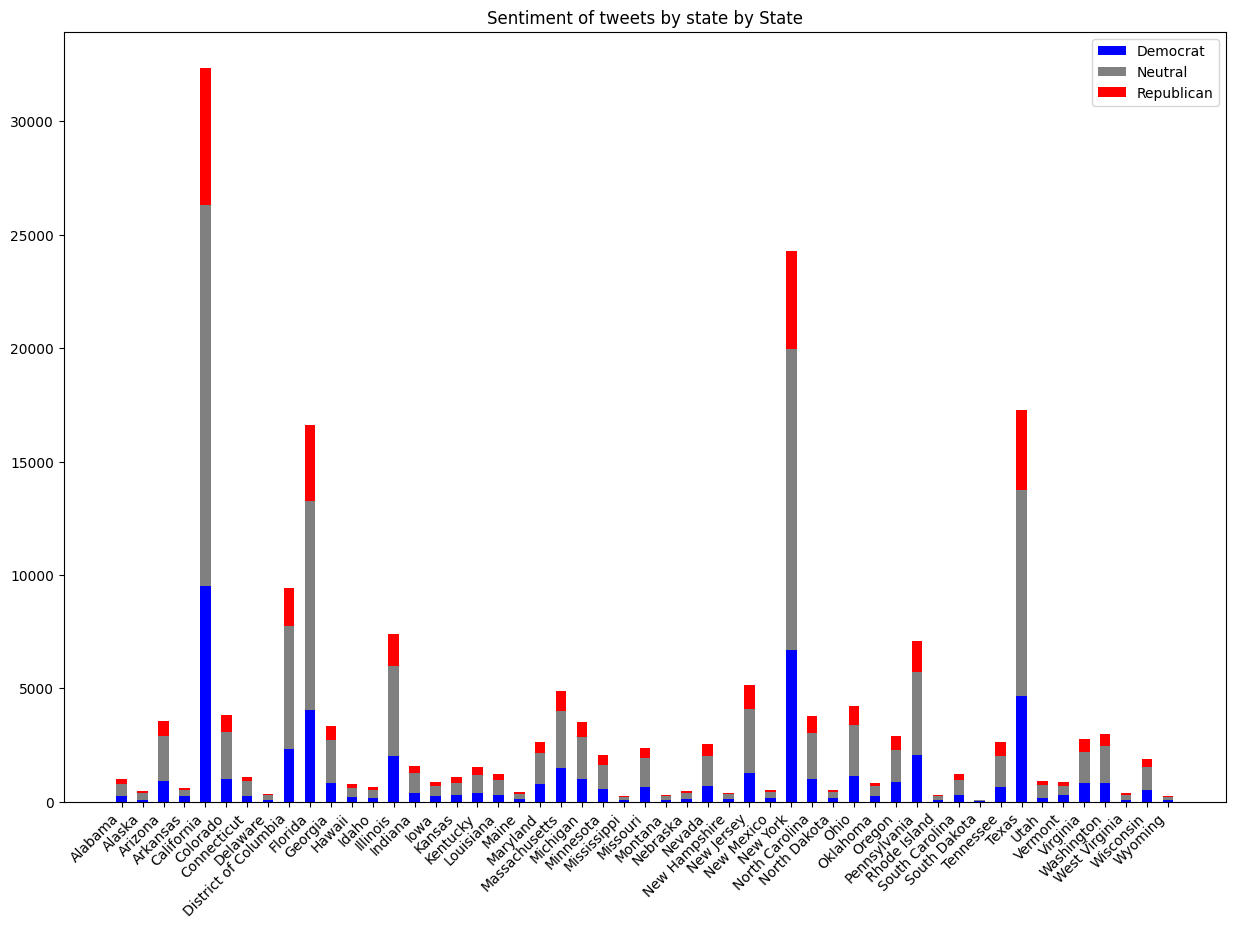

In [10]:
dict_for_bar = { "Democrat": np.array([]),"Neutral": np.array([]), "Republican": np.array([])}
states = []
for i in sentiment_counts_no_bias.iterrows():
    dict_for_bar["Democrat"] = np.append(dict_for_bar["Democrat"], i[1][1])
    dict_for_bar["Neutral"] =np.append(dict_for_bar["Neutral"], i[1][0])
    dict_for_bar["Republican"] = np.append(dict_for_bar["Republican"], i[1][2])
    states.append(i[0])

dict_colors = {"Neutral": "grey", "Democrat": "blue", "Republican": "red"}
fig, ax = plt.subplots(figsize=(15, 10))
bottom = np.zeros(len(states))
for label,count in dict_for_bar.items():
    p = ax.bar(states, count, width=0.5, label=label, bottom=bottom, color =dict_colors[label]) 
    bottom += count

ax.set_title("Sentiment of tweets by state by State")
ax.legend(loc="upper right")
plt.xticks(rotation=45, ha='right')
plt.show()

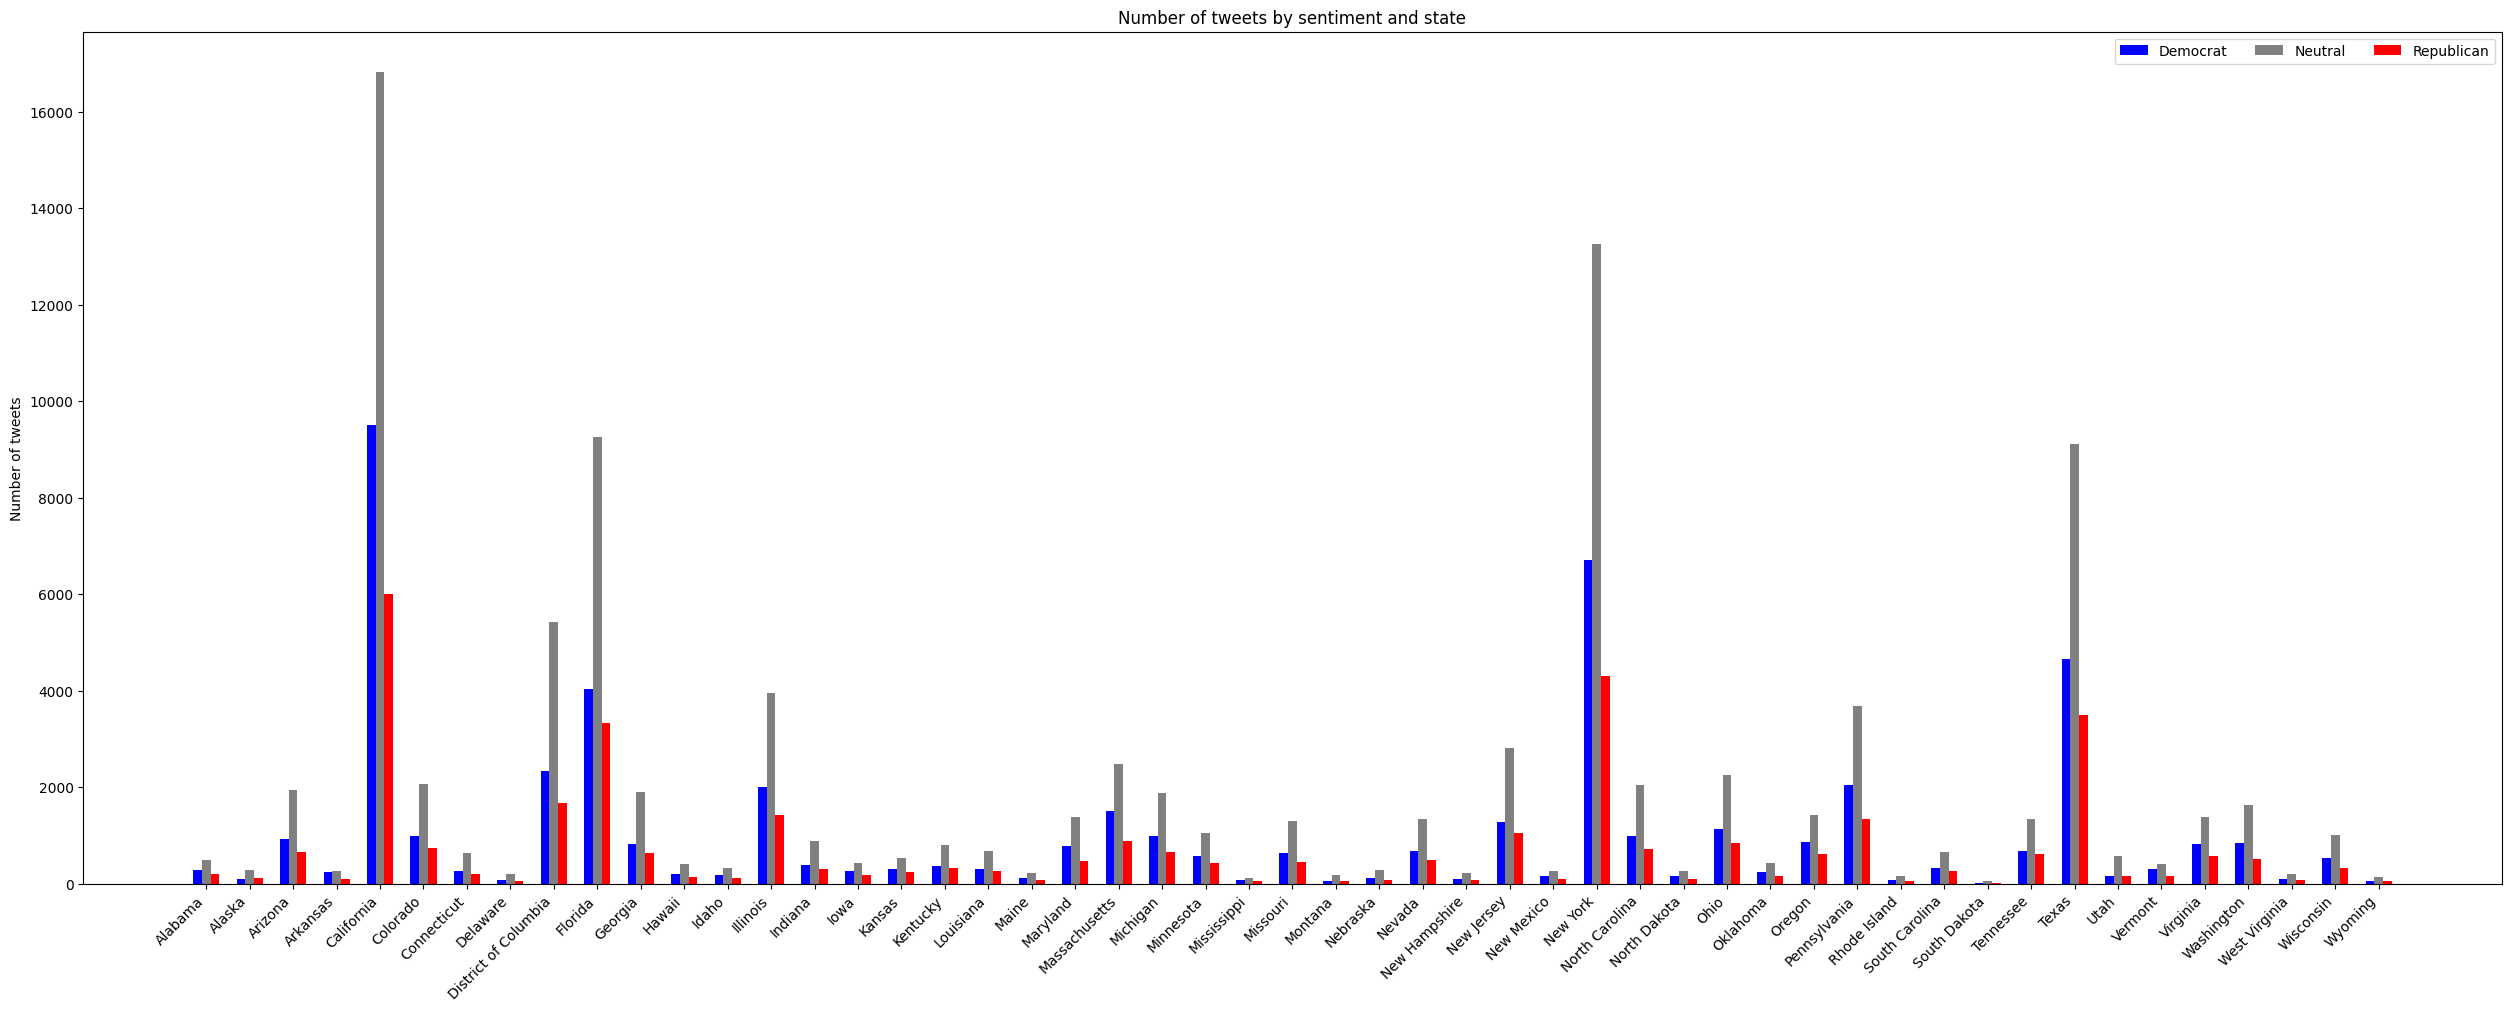

In [11]:
fig, ax = plt.subplots(layout='constrained', figsize=(25, 10))
multiplier = 0
width =0.2 
for label, sentiment_tweets in dict_for_bar.items():
    offset = width * multiplier
    rects = ax.bar(np.arange(len(states)) + offset, sentiment_tweets, width, label=label, color=dict_colors[label])
    multiplier += 1
ax.set_ylabel('Number of tweets')
ax.set_title('Number of tweets by sentiment and state')
ax.set_xticks(np.arange(len(states)) + width, states,rotation=45, ha='right')
ax.legend(loc='upper right', ncols=3)
plt.show()
